### Identify if there are characteristics that might signify revolutions (major leaps) in musical evolution from these data? What artists represent revolutionaries (influencers of major change) in your network?

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import math

In [3]:
artists = pd.read_csv('data_by_artist.csv')
artists = artists.drop_duplicates(subset='artist_name', keep='last')
artists[80:90]

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count
88,Bill Evans,764702,0.484232,0.226042,0.356796,103.714032,-17.886479,1,0,0.879193,0.634696,0.135222,0.043088,310919.1286,25.903571,280
89,Bee Gees,43714,0.558565,0.510842,0.597418,107.119078,-11.204190,1,7,0.247674,0.046172,0.245669,0.039678,228251.3048,42.553903,269
90,"Hank Williams, Jr.",117844,0.618721,0.531600,0.650446,116.387245,-11.890305,1,2,0.235158,0.000915,0.156218,0.043623,201087.3420,35.992565,269
91,Journey,291043,0.410357,0.742483,0.422064,129.048171,-7.296829,1,2,0.121834,0.024602,0.295605,0.051768,241786.7323,38.691450,269
92,Depeche Mode,239921,0.614566,0.686984,0.605943,122.395015,-10.619378,1,0,0.242001,0.225370,0.219982,0.040369,266381.1536,34.655431,267
93,Wings,956707,0.512932,0.477410,0.536398,120.549286,-12.245338,1,2,0.316919,0.052453,0.322316,0.047668,244458.8421,34.924812,266
94,Neil Diamond,864209,0.470415,0.429215,0.516642,109.570664,-13.323083,1,9,0.412821,0.044129,0.223986,0.043433,205188.1509,35.550943,265
95,Electric Light Orchestra,163229,0.492553,0.565447,0.532085,122.037053,-9.983311,1,9,0.450906,0.064320,0.265527,0.040286,247267.5000,39.409091,264
96,Aerosmith,604852,0.440015,0.790477,0.536305,127.873015,-7.660576,1,9,0.078511,0.033241,0.263158,0.047703,266323.1364,40.340909,264
97,Henry Mancini,678009,0.481968,0.360791,0.465710,114.084319,-13.680916,1,0,0.775519,0.495249,0.140303,0.036779,166908.2662,19.775665,263


In [4]:
years = pd.read_csv('data_by_year.csv')
years

,year,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity
0,1921,0.425661,0.236784,0.425495,100.397758,-17.095437,1,7,0.895823,0.322330,0.215814,0.077258,229911.9141,0.351562
1,1922,0.480000,0.237026,0.534056,101.376139,-19.179958,1,10,0.939236,0.440470,0.238647,0.115419,167904.5417,0.138889
2,1923,0.568462,0.246936,0.624788,112.456598,-14.373882,1,0,0.976329,0.401932,0.236656,0.098619,178356.3018,5.727811
3,1924,0.548654,0.347033,0.668574,120.653359,-14.202304,1,10,0.935575,0.583955,0.237875,0.090210,188461.6498,0.603376
4,1925,0.571890,0.264373,0.616430,115.671715,-14.516707,1,5,0.965422,0.408893,0.243094,0.115457,184130.6996,2.707224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016,0.599976,0.592877,0.430769,119.070344,-7.949913,1,0,0.280290,0.074646,0.180198,0.107298,219400.7638,61.371254
96,2017,0.612286,0.586739,0.414465,116.840277,-8.422697,1,1,0.289916,0.098209,0.194218,0.111752,209343.6130,64.861500
97,2018,0.664930,0.590591,0.447141,122.004325,-7.253666,1,1,0.271941,0.035948,0.171781,0.128140,200919.1190,67.276000
98,2019,0.644215,0.578796,0.465856,118.868163,-8.041738,1,1,0.289298,0.076518,0.167161,0.124799,197733.1330,69.655500


In [6]:
influence = pd.read_csv('influence_data.csv')

In [7]:
from tqdm import tqdm
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in tqdm(range(len(full))): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')

artistGenres = {} #adds song genre to full
for i in tqdm(range(len(influence))):
    row = influence.iloc[i]
    influencer = row['influencer_id']
    follower = row['follower_id']
    infGenre = row['influencer_main_genre']
    folGenre = row['follower_main_genre']
    artistGenres[influencer] = infGenre
    artistGenres[follower] = folGenre

def getGenre(row):
    artist = row['artists_id']
    if type(artist) == list:
        print(row)
    try:
        genre = artistGenres[artist]
    except KeyError:
        genre = 'N/A'
    return genre

full['genre'] = full.apply(lambda row: getGenre(row), axis = 1)

full


  0%|                                                                                        | 0/98340 [00:00<?, ?it/s]C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,Electronic
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,Electronic
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,Electronic
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102913,ZZ Top,690254,0.276,0.892,0.715,0.329693,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,0,115973,33,1975,4/18/1975,Jailhouse Rock - **** Remaster,Pop/Rock
102914,ZZ Top,690254,0.700,0.592,0.906,0.450025,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,0,263627,32,1976,11/29/1976,It's Only Love,Pop/Rock
102915,ZZ Top,690254,0.709,0.709,0.863,0.456977,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,0,158400,31,1987,1987,Balinese,Pop/Rock
102916,ZZ Top,690254,0.552,0.651,0.533,0.661835,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,0,232533,43,1992,4/13/1992,La Grange - **** Remaster,Pop/Rock


In [8]:
idDict = {}
for i in range(len(artists)):
    try:
        idDict[artists['artist_id'][i]] = artists['artist_name'][i]
    except:
        pass

iGraph = nx.DiGraph()
for artist in artists['artist_id']:
    iGraph.add_node(artist, weight = 0)
    
for i in range(len(influence)):
    influencer = influence["influencer_id"][i]
    follower = influence['follower_id'][i]
    
    iGraph.add_edge(influencer,follower)    

arts = []
artnames = []
scores = []
for node in iGraph.nodes():
    children = list(iGraph.successors(node))
    total = 0
    for child in children:
        total += iGraph.out_degree[child]
        
    iGraph.nodes[node]['weight'] = total
    arts.append(node)
    try:
        artnames.append(idDict[node])
    except KeyError:
        artnames.append('Unknown')
    scores.append(total)
    
   
totalInfluence = pd.DataFrame({'names':artnames, 'artists':arts, 'scores':scores})
totalInfluence = totalInfluence.sort_values(by=['scores'], ascending = False)
totalInfluence = totalInfluence.reset_index(drop=True)
totalInfluence

,names,artists,scores
0,The Beatles,754032,11237
1,Bob Dylan,66915,7928
2,The Rolling Stones,894465,6341
3,Chuck Berry,120521,5897
4,Elvis Presley,180228,4749
...,...,...,...
5848,She Wants Revenge,328201,0
5849,Jonathan Coulton,329542,0
5850,No Use for a Name,344037,0
5851,Jet,346806,0


In [13]:
def mostInfluential(years, trait, ascent):
    songs = full[full['year'].isin(years)]
    songs = songs.sort_values(by=[trait], ascending=ascent)
    songs = songs.reset_index(drop=True)
    influentialArtists = []
    for i in range(math.floor(0.01*len(songs))):
        df = totalInfluence[totalInfluence['names'] == songs['artist_names'][i]]
        if len(df) > 0:
            index = df.index[0]
            if index < 0.05 * len(totalInfluence):
                influentialArtists.append(songs['artist_names'][i])   
    influentialArtists = set(influentialArtists)
    influentialArtists = list(influentialArtists)
    return influentialArtists

In [78]:
def changeDriver(years, trait, ascent):
    songs = full[full['year'].isin(years)]
    songs = songs.sort_values(by=[trait], ascending=ascent)
    songs = songs.reset_index(drop=True)
    influentialArtists = []
    for i in range(math.floor(0.5* len(songs))):
        df = totalInfluence[totalInfluence['names'] == songs['artist_names'][i]]
        if len(df) > 0:
            index = df.index[0]
            if index < 0.05 * len(totalInfluence):
                influentialArtists.append(songs['artist_names'][i])   
    influentialArtists = set(influentialArtists)
    influentialArtists = list(influentialArtists)
    return influentialArtists

In [10]:
years['hipness'] = years['speechiness'] - years['instrumentalness'] - years['acousticness']
full['hipness'] = full['speechiness'] - full['instrumentalness'] - full['acousticness']

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


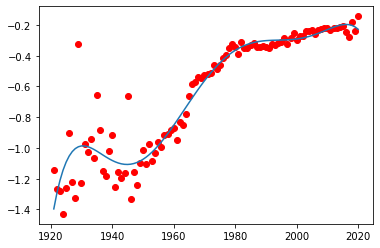

In [11]:
year = years['year']
attribute = years['hipness']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 7))(np.unique(year)))

In [14]:
hipTrans = years[years['year'] <= 1980]
hipTrans = hipTrans[hipTrans['year'] > 1960]
hipYears = list(hipTrans['year'])
mostInfluential(hipYears, 'hipness', False)

['The Byrds',
 'New York Dolls',
 'Jacques Brel',
 'Joy Division',
 'The Doors',
 'Thin Lizzy',
 'Smokey Robinson',
 'The Isley Brothers',
 'The Damned',
 'Frank Sinatra',
 'The Clash',
 'Funkadelic',
 'Gang of Four',
 'Pink Floyd',
 'Van Morrison',
 'Peter Tosh',
 'The Kinks',
 'The Beatles',
 'Queen',
 'Bobby Womack',
 'Patti Smith',
 'Sly & the Family Stone',
 'Kiss',
 'Deep Purple',
 'Jimmy Cliff',
 'Simon & Garfunkel',
 'Iron Maiden',
 'T. Rex',
 'Otis Redding',
 'Wilson Pickett',
 'The Who',
 'Johnny Cash',
 'AC/DC',
 'David Bowie',
 'Jimi Hendrix',
 'Sex Pistols',
 'Marvin Gaye',
 'Alice Cooper',
 'Elvis Costello',
 'Judas Priest',
 'Sam Cooke',
 'Parliament',
 'MC5',
 'Yes',
 'Bob Dylan',
 'Mott the Hoople',
 'Talking Heads',
 'Led Zeppelin',
 'The Stooges',
 'James Brown',
 'Frank Zappa',
 'John Lennon',
 'The Beach Boys']

In [ ]:
minSpeech = years.sort_values(by=['speechiness'])
minSpeech = minSpeech.reset_index(drop=True)
minYears = []
for i in range(5):
    minYears.append(minSpeech['year'][i])
    


C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


<function matplotlib.pyplot.legend(*args, **kwargs)>

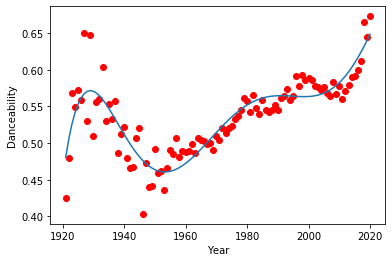

In [103]:
year = years['year']
attribute = years['danceability']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 7))(np.unique(year)), label='Valence')
plt.ylabel('Danceability')
plt.xlabel('Year')
plt.legend

In [108]:
years['party'] = years['loudness'] + years['danceability'] + years['energy']
full['party'] = full['loudness'] + full['danceability'] + years['energy']

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


<function matplotlib.pyplot.legend(*args, **kwargs)>

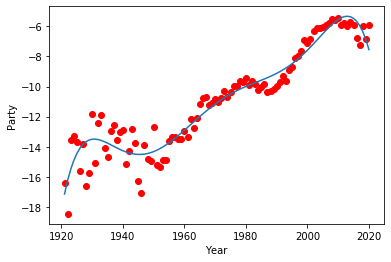

In [109]:
year = years['year']
attribute = years['party']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 7))(np.unique(year)), label='Valence')
plt.ylabel('Party')
plt.xlabel('Year')
plt.legend

In [19]:
danceTrans = years[years['year'] <= 2010]
danceTrans = danceTrans[danceTrans['year'] > 1995]
danceYears = list(danceTrans['year'])
mostInfluential(danceYears, 'party', False)

['Metallica', 'Michael Jackson']

In [44]:
years

,year,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,hipness,party
0,1921,0.425661,0.236784,0.425495,100.397758,-17.095437,1,7,0.895823,0.322330,0.215814,0.077258,229911.9141,0.351562,-1.140896,13.449551
1,1922,0.480000,0.237026,0.534056,101.376139,-19.179958,1,10,0.939236,0.440470,0.238647,0.115419,167904.5417,0.138889,-1.264287,11.712883
2,1923,0.568462,0.246936,0.624788,112.456598,-14.373882,1,0,0.976329,0.401932,0.236656,0.098619,178356.3018,5.727811,-1.279642,19.931559
3,1924,0.548654,0.347033,0.668574,120.653359,-14.202304,1,10,0.935575,0.583955,0.237875,0.090210,188461.6498,0.603376,-1.429320,22.542358
4,1925,0.571890,0.264373,0.616430,115.671715,-14.516707,1,5,0.965422,0.408893,0.243094,0.115457,184130.6996,2.707224,-1.258858,20.756697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016,0.599976,0.592877,0.430769,119.070344,-7.949913,1,0,0.280290,0.074646,0.180198,0.107298,219400.7638,61.371254,-0.247638,28.371167
96,2017,0.612286,0.586739,0.414465,116.840277,-8.422697,1,1,0.289916,0.098209,0.194218,0.111752,209343.6130,64.861500,-0.276373,27.241672
97,2018,0.664930,0.590591,0.447141,122.004325,-7.253666,1,1,0.271941,0.035948,0.171781,0.128140,200919.1190,67.276000,-0.179749,30.012561
98,2019,0.644215,0.578796,0.465856,118.868163,-8.041738,1,1,0.289298,0.076518,0.167161,0.124799,197733.1330,69.655500,-0.241016,28.262926


In [62]:
yearVecs = []
cyears = years.drop(columns=['loudness', 'mode', 'key', 'liveness', 'duration_ms', 'popularity'])
for i in cyears['year']:
    test = cyears[cyears['year'] == i].to_numpy()
    test = np.delete(test, 0, 1)
    yearVecs.append(test)
j = 1
diff = [0]
while j < len(yearVecs):
    diff.append(1000 * cosine_similarity(yearVecs[j], yearVecs[j - 1])[0][0])
    j += 1
diff
    
    

[0,
 999.8334362080859,
 998.176424984109,
 999.9552089578754,
 999.9727148772496,
 999.6846136356941,
 999.7371097078698,
 999.4056300727424,
 999.8348990149159,
 999.4456603299286,
 999.525625094398,
 999.4992518260646,
 999.9925388326176,
 999.8494580581447,
 999.9302975929079,
 999.8985946431062,
 999.9646823672374,
 999.9436552741225,
 999.9786411500761,
 999.9859853628589,
 999.768904518448,
 999.9792905646186,
 999.9113303008552,
 999.976970624729,
 999.7517716686954,
 999.8420919721275,
 999.2497007305191,
 999.9404664267365,
 999.9978963025808,
 999.7518244196857,
 999.6937837759267,
 999.994791264817,
 999.9806382594124,
 999.9995363084545,
 999.9132028534999,
 999.9928688471682,
 999.999531528176,
 999.9997284175358,
 999.9997112805439,
 999.9865563234704,
 999.9916797487906,
 999.9261711882599,
 999.9871518064168,
 999.9844087201865,
 999.950978111299,
 999.9979461901572,
 999.9981806191981,
 999.986066509956,
 999.9992142154339,
 999.9976565270017,
 999.9996458364926,
 999

In [66]:
transitions = pd.DataFrame(years['year'])
transitions['Cosine Similarity to Previous Year'] = pd.Series(diff)
transitions = transitions.sort_values(by=['Cosine Similarity to Previous Year'])
transitions

,year,Cosine Similarity to Previous Year
0,1921,0.000000
2,1923,998.176425
26,1947,999.249701
7,1928,999.405630
9,1930,999.445660
...,...,...
84,2005,999.999746
65,1986,999.999751
67,1988,999.999852
88,2009,999.999920


<function matplotlib.pyplot.legend(*args, **kwargs)>

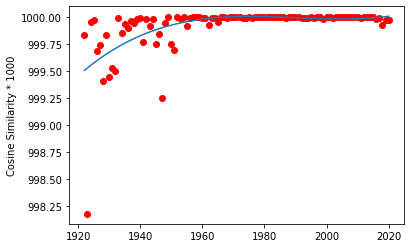

In [111]:
#transition graph
year = transitions['year'][1:]
attribute = transitions['Cosine Similarity to Previous Year'][1:]
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 3))(np.unique(year)))
plt.ylabel('Cosine Similarity * 1000')
plt.legend

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


<function matplotlib.pyplot.legend(*args, **kwargs)>

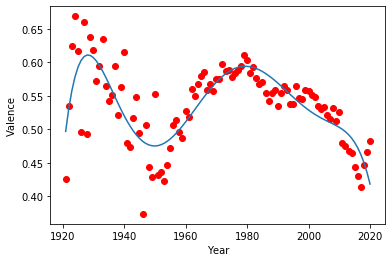

In [101]:
year = years['year']
attribute = years['valence']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 7))(np.unique(year)), label='Valence')
plt.ylabel('Valence')
plt.xlabel('Year')
plt.legend

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


<function matplotlib.pyplot.legend(*args, **kwargs)>

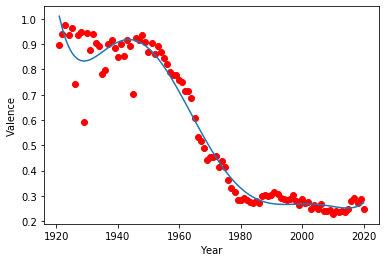

In [118]:
year = years['year']
attribute = years['acousticness']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 7))(np.unique(year)), label='Valence')
plt.ylabel('Valence')
plt.xlabel('Year')
plt.legend

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


<function matplotlib.pyplot.legend(*args, **kwargs)>

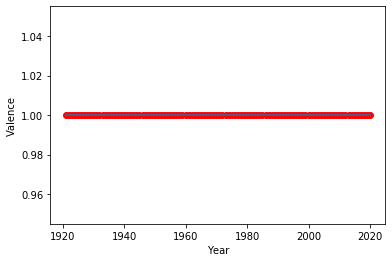

In [119]:
year = years['year']
attribute = years['mode']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 7))(np.unique(year)), label='Valence')
plt.ylabel('Valence')
plt.xlabel('Year')
plt.legend

In [126]:
lowValence1947 = changeDriver([1947], 'valence', True)
highValence1947 = changeDriver([1947], 'valence', False)
lv47songs = full[full['artist_names'].isin(lowValence1947)]
#lv47songs = lv47songs[lv47songs['year'] == 1947]
print(lv47songs['mode'].mean())
hv47songs = full[full['artist_names'].isin(highValence1947)]
hv47songs = hv47songs[hv47songs['year'] == 1947]
print(hv47songs['mode'].mean())

0.9256198347107438
0.7916666666666666


In [125]:
changeDriver([1947], 'valence', True)

['Roy Orbison', 'Merle Haggard', 'Chet Atkins', 'Willie Dixon']

In [ ]:
#Sharp decrease in similarity in 1947 due to country songs from extremely influential artists

In [115]:
changeDriver([1947], 'energy', True)

['Merle Haggard', 'Willie Dixon']

In [117]:
changeDriver([1947], 'danceability', True)

['Roy Orbison', 'Ray Charles']

In [ ]:
songStats = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness']        
stats = artists[songStats]
cormatrix = np.zeros((len(songStats),len(songStats)))
for i in range(len(songStats)):
    stat1 = songStats[i]
    col1 = np.array(artists[stat1])
    for j in range(len(songStats)):
        stat2 = songStats[j]
        col2 = np.array(artists[stat2])
        coef = np.corrcoef(col1,col2)[0][1]
        cormatrix[i][j] = coef
pd.DataFrame(cormatrix, index = songStats, columns = songStats)